Questions – 
1)	Find out the make and model that is most represented and the one that is least represented class? Is there a class imbalance problem, how would you handle class imbalance if it were to exist (2 marks)
2)	Apply the image processing techniques and explain the benefits of those technique (2 marks)
3)	Train a lightweight model, show train and validation loss curves, show steps taken to tune hyper params (1 marks)
4)	Determine metric to evaluate performance of the model. Report how the model is performing on the metric (2 Marks)
5)	Deploy (3 marks)
a.	As a rest api endpoint
b.	Mobil app model


# Car Images classification using CNN

# Import Modules

In [8]:
# import the libraries as shown below
import os
import shutil
import random
import numpy as np
import numpy as np
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

In [4]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.4.1


In [18]:
#Set all the Constants
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=50

In [6]:
#defining the path
train_path = 'train'
valid_path = 'test'


# 1)	Find out the make and model that is most represented and the one that is least represented class? 

In [8]:
data_dir = train_path 
class_counts = {}

for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        class_count = len(os.listdir(class_dir))
        class_counts[class_name] = class_count

# Find the most and least represented classes
most_represented_class = max(class_counts, key=class_counts.get)
least_represented_class = min(class_counts, key=class_counts.get)

print(f"Most Represented Class: {most_represented_class}, Count: {class_counts[most_represented_class]}")
print(f"Least Represented Class: {least_represented_class}, Count: {class_counts[least_represented_class]}")

Most Represented Class: Audi, Count: 814
Least Represented Class: Hyundai Creta, Count: 271


# Is there a class imbalance problem, how would you handle class imbalance if it were to exist   Apply the image processing techniques and explain the benefits of those technique

In [9]:
train_folder = train_path 
# Initialize an empty dictionary to store class counts
class_counts = {}

# Iterate through the subfolders (each representing a class)
for class_folder in os.listdir(train_folder):
    if os.path.isdir(os.path.join(train_folder, class_folder)):
        # Count the number of files (images) in each class folder
        class_count = len(os.listdir(os.path.join(train_folder, class_folder)))
        # Store the class count in the dictionary with the class name as the key
        class_counts[class_folder] = class_count

# Print the class distribution for the training set
for car_class, count in class_counts.items():
    print(f"Class: {car_class}, Count: {count}")


Class: Hyundai Creta, Count: 271
Class: Mahindra Scorpio, Count: 316
Class: Swift, Count: 424
Class: Rolls Royce, Count: 311
Class: Tata Safari, Count: 441
Class: Toyota Innova, Count: 775
Class: Audi, Count: 814


In [13]:
#balance dataset
# Define the path to your train data directory
train_data_dir = 'train'  # Update with your actual path

# Create a directory for balanced training data
balanced_train_dir = 'balanced_train_dir'
os.makedirs(balanced_train_dir, exist_ok=True)
 Create an instance of the ImageDataGenerator with desired transformations
datagen = ImageDataGenerator(
    rescale=1./255,               # Normalize pixel values to the range [0, 1]
    rotation_range=20,            # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,        # Randomly shift the width of images by up to 20%
    height_shift_range=0.2,       # Randomly shift the height of images by up to 20%
    shear_range=0.2,              # Randomly apply shear transformations
    zoom_range=0.2,               # Randomly zoom in on images by up to 20%
    horizontal_flip=True,         # Randomly flip images horizontally
    fill_mode='nearest'           # Fill in empty areas created by transformations
)

# Define the desired count for 'Audi'
desired_count = 814

# List all class directories and their counts
class_directories = os.listdir(train_data_dir)
class_counts = {}

# Iterate through each class directory
for class_name in class_directories:
    class_dir = os.path.join(train_data_dir, class_name)
    class_files = os.listdir(class_dir)

    # Create a directory for the class in the balanced dataset
    balanced_class_dir = os.path.join(balanced_train_dir, class_name)
    os.makedirs(balanced_class_dir, exist_ok=True)

    # Calculate the number of samples needed for this class to match the desired count
    num_original_samples = len(class_files)
    num_samples_to_copy = min(desired_count, num_original_samples)

    # Calculate the number of samples needed to augment
    num_samples_to_augment = desired_count - num_samples_to_copy

    # Copy the original samples to the balanced dataset
    files_to_copy = random.sample(class_files, num_samples_to_copy)
    for file_name in files_to_copy:
        src_path = os.path.join(class_dir, file_name)
        dst_path = os.path.join(balanced_class_dir, file_name)
        shutil.copy(src_path, dst_path)

    # Update the class counts
    class_counts[class_name] = num_samples_to_copy

    # Apply data augmentation if needed
    if num_samples_to_augment > 0:
        # Iterate through the original samples and apply augmentation
        for i in range(num_samples_to_augment):
            # Randomly select an image from the original samples
            original_image_name = random.choice(class_files)
            original_image_path = os.path.join(class_dir, original_image_name)

            # Load the image using PIL (Pillow)
            img = load_img(original_image_path)
            
            # Convert the image to a NumPy array
            img_array = img_to_array(img)

            # Reshape the image to (1, height, width, channels)
            img_array = np.expand_dims(img_array, axis=0)

            # Generate augmented images using the data generator
            augmented_images = datagen.flow(img_array, batch_size=1)

            # Get the first augmented image from the generator
            augmented_image_array = next(augmented_images)[0].astype(np.uint8)
            augmented_image = array_to_img(augmented_image_array)

            # Save the augmented image with a new name
            augmented_image_name = f"augmented_{i}_{original_image_name}"
            augmented_image_path = os.path.join(balanced_class_dir, augmented_image_name)
            augmented_image.save(augmented_image_path)




Rescaling (Normalization):

Benefit: Normalizing pixel values to the range [0, 1] helps in convergence during training by ensuring that the model deals with small and consistent input values.
Rotation, Width Shift, Height Shift, Shear, and Zoom:

Benefit: These transformations increase the diversity of your training data. They help the model become robust to variations in input images, such as changes in orientation, position, and scale.
Horizontal Flip:

Benefit: Flipping images horizontally introduces mirror-image versions of existing data, further enhancing dataset diversity and training stability.
Fill Mode (Nearest):

Benefit: This mode fills in areas of the image that may become empty due to transformations like rotation or shearing. It ensures that no information is lost during augmentation.


In [14]:
#after blanching dataset

In [10]:
train_folder =  'balanced_train_dir' 
# Initialize an empty dictionary to store class counts
class_counts = {}

# Iterate through the subfolders (each representing a class)
for class_folder in os.listdir(train_folder):
    if os.path.isdir(os.path.join(train_folder, class_folder)):
        # Count the number of files (images) in each class folder
        class_count = len(os.listdir(os.path.join(train_folder, class_folder)))
        # Store the class count in the dictionary with the class name as the key
        class_counts[class_folder] = class_count

# Print the class distribution for the training set
for car_class, count in class_counts.items():
    print(f"Class: {car_class}, Count: {count}")

Class: Hyundai Creta, Count: 814
Class: Mahindra Scorpio, Count: 814
Class: Swift, Count: 814
Class: Rolls Royce, Count: 814
Class: Tata Safari, Count: 814
Class: Toyota Innova, Count: 814
Class: Audi, Count: 814


# Train a lightweight model, show train and validation loss curves, show steps taken to tune hyper params 

In [19]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "balanced_train_dir",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5698 files belonging to 7 classes.


In [20]:
class_names = dataset.class_names
print(class_names)
len(class_names)

['Audi', 'Hyundai Creta', 'Mahindra Scorpio', 'Rolls Royce', 'Swift', 'Tata Safari', 'Toyota Innova']


7

In [17]:
len(dataset)

179

In [79]:
class_labels = training_set.class_indices
print(class_labels)

{'Audi': 0, 'Hyundai Creta': 1, 'Mahindra Scorpio': 2, 'Rolls Royce': 3, 'Swift': 4, 'Tata Safari': 5, 'Toyota Innova': 6}


In [18]:
class_labels = np.array(dataset.class_names)
print(class_labels)

['Audi' 'Hyundai Creta' 'Mahindra Scorpio' 'Rolls Royce' 'Swift'
 'Tata Safari' 'Toyota Innova']


In [80]:
class_labels_list = list(class_labels.keys())
print(class_labels_list)


['Audi', 'Hyundai Creta', 'Mahindra Scorpio', 'Rolls Royce', 'Swift', 'Tata Safari', 'Toyota Innova']


# Visualize Dataset

2023-09-10 02:01:51.512802: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-09-10 02:01:51.529881: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2599990000 Hz


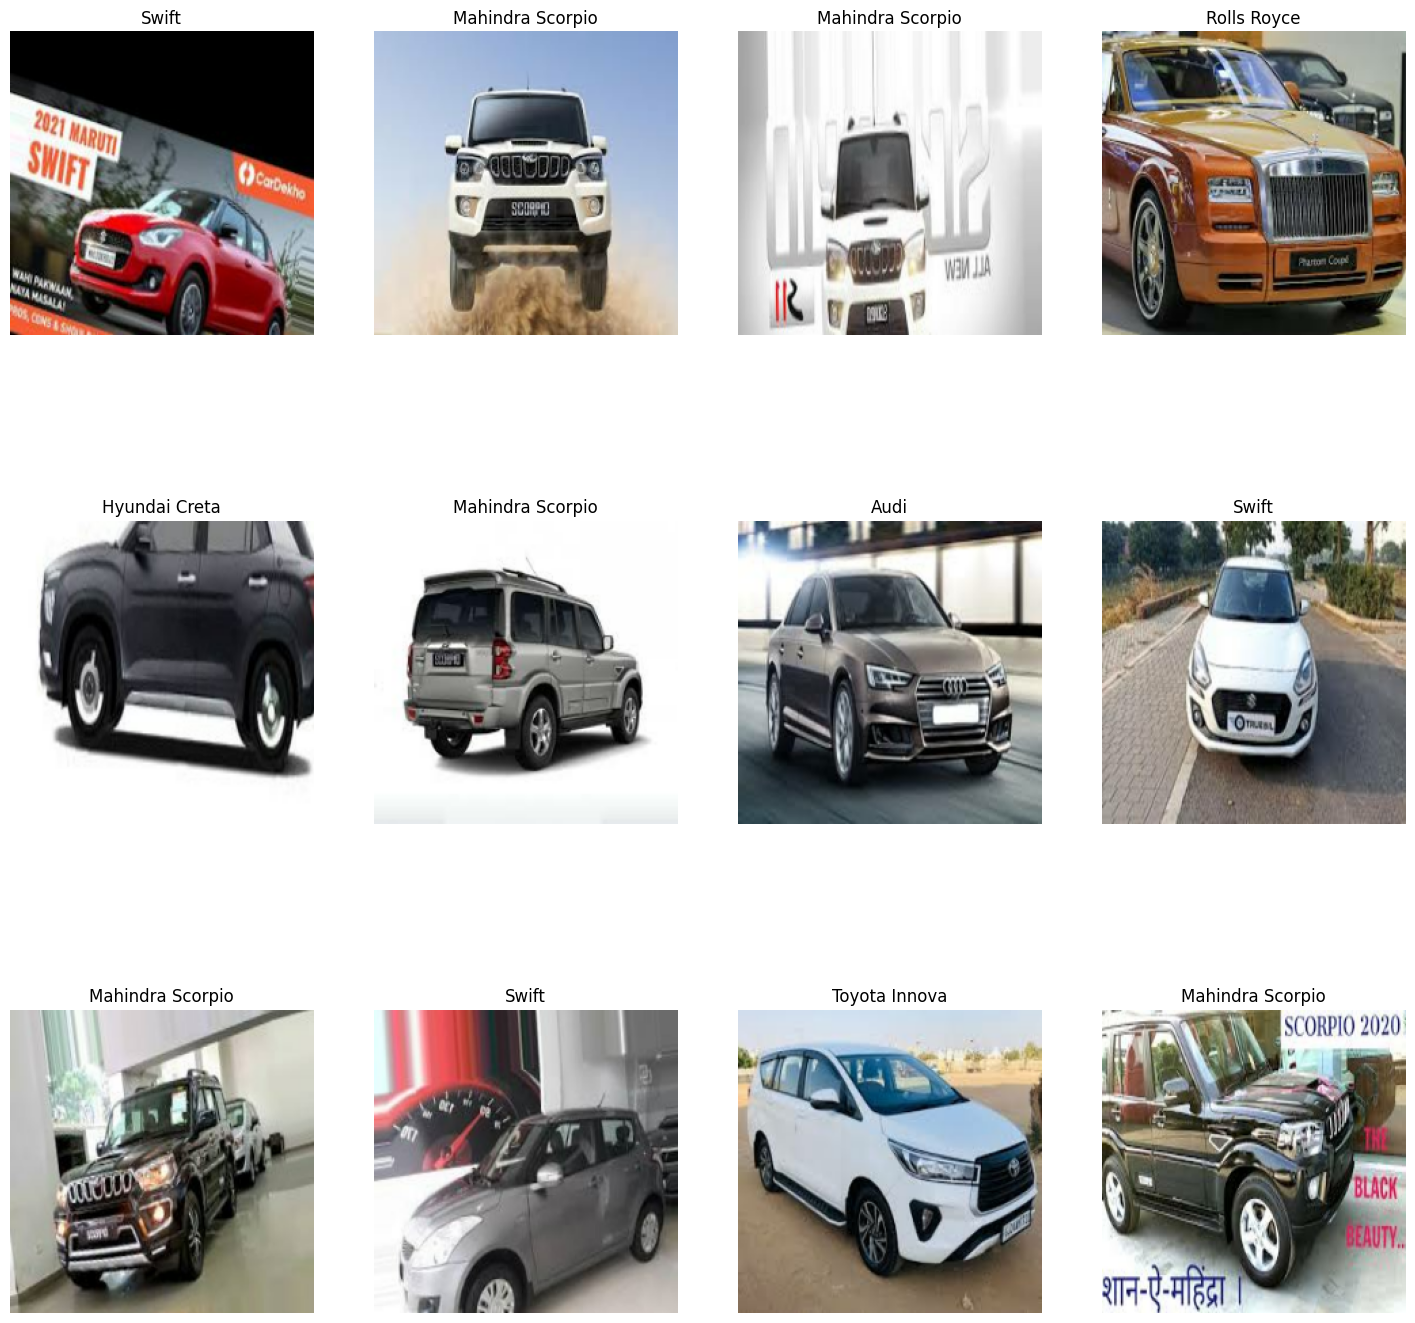

In [19]:
#plotting somesamples
plt.figure(figsize=(18, 18))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# Create Model

In [20]:
#importing model
# Here we will be using imagenet weights
IMAGE_SIZE = [224, 224]

resnet = ResNet50(input_shape=IMAGE_SIZE  + [3], weights='imagenet', include_top=False)


In [21]:
# don't train existing weights
for layer in resnet.layers:
    layer.trainable = False

In [22]:
  # useful for getting number of output classes
folders = glob("balanced_train_dir/*")

In [23]:
# our layers 
x = Flatten()(resnet.output)

In [24]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=resnet.input, outputs=prediction)

In [25]:

# view the structure of the model
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [26]:
# Compiling the model
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


In [10]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [11]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('balanced_train_dir',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 5698 images belonging to 7 classes.


In [12]:
test_set = test_datagen.flow_from_directory('test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 813 images belonging to 7 classes.


In [40]:

# Define a learning rate schedule
def lr_schedule(epoch):
    if epoch < 10:
        return 0.001
    elif epoch < 20:
        return 0.0001
    else:
        return 0.00001

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)




In [42]:
# fit the model
# Run the cell. It will take some time to execute
# Train the model with hyperparameter tuning
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
    callbacks=[LearningRateScheduler(lr_schedule), early_stopping]
)

Epoch 1/50
179/179 [==============================] - 210s 1s/step - loss: 2.6638 - accuracy: 0.2701 - val_loss: 2.0943 - val_accuracy: 0.3752
Epoch 2/50
179/179 [==============================] - 226s 1s/step - loss: 2.0530 - accuracy: 0.3582 - val_loss: 1.9982 - val_accuracy: 0.3629
Epoch 3/50
179/179 [==============================] - 205s 1s/step - loss: 1.8957 - accuracy: 0.4103 - val_loss: 2.2804 - val_accuracy: 0.3678
Epoch 4/50
179/179 [==============================] - 203s 1s/step - loss: 1.7882 - accuracy: 0.4502 - val_loss: 2.0547 - val_accuracy: 0.4145
Epoch 5/50
179/179 [==============================] - 207s 1s/step - loss: 1.4617 - accuracy: 0.5081 - val_loss: 1.6201 - val_accuracy: 0.4772
Epoch 6/50
179/179 [==============================] - 207s 1s/step - loss: 1.5643 - accuracy: 0.5146 - val_loss: 1.5920 - val_accuracy: 0.4994
Epoch 7/50
179/179 [==============================] - 203s 1s/step - loss: 1.3692 - accuracy: 0.5462 - val_loss: 1.3316 - val_accuracy: 0.5781

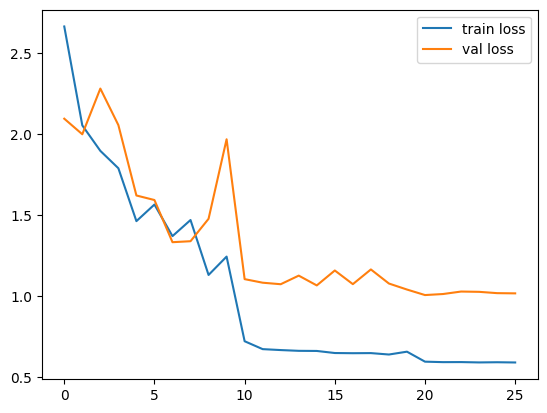

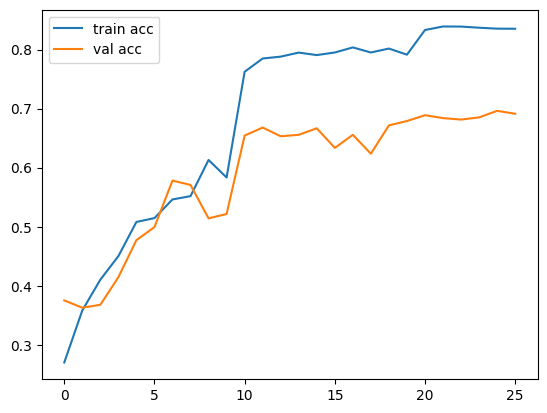

<Figure size 640x480 with 0 Axes>

In [43]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
# Val Accuarcy is 0.6913 only 

# fine tuning the model 

In [45]:
# Define the image size, batch size, and other hyperparameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Create a data generator with aggressive data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,       # Increased rotation range
    width_shift_range=0.3,   # Increased width shift range
    height_shift_range=0.3,  # Increased height shift range
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create a data generator for validation (no augmentation)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Load and prepare the training data
train_generator = train_datagen.flow_from_directory(
    'balanced_train_dir',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Load and prepare the validation data
validation_generator = validation_datagen.flow_from_directory(
    'test',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 5698 images belonging to 7 classes.
Found 813 images belonging to 7 classes.


In [50]:

# Load the pre-trained ResNet50 model
resnet = ResNet50(input_shape=IMAGE_SIZE + (3,), weights='imagenet', include_top=False)

# Fine-tune some of the later layers of the ResNet50 base
for layer in resnet.layers[:-10]:  # Fine-tuning last 10 layers
    layer.trainable = True

# Add custom classification layers with dropout
x = Flatten()(resnet.output)
x = Dropout(0.5)(x)  # Added dropout layer
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

# Create the model
model = Model(inputs=resnet.input, outputs=predictions)

# Compile the model with a lower learning rate
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(lr=0.0001),  # Adjusted learning rate
    metrics=['accuracy']
)


In [51]:
# Train the model with increased batch size
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[LearningRateScheduler(lr_schedule), early_stopping]
)

Epoch 1/50
179/179 [==============================] - 942s 5s/step - loss: 5.3101 - accuracy: 0.1837 - val_loss: 206.5125 - val_accuracy: 0.0923
Epoch 2/50
179/179 [==============================] - 934s 5s/step - loss: 2.2589 - accuracy: 0.1859 - val_loss: 3.1113 - val_accuracy: 0.0923
Epoch 3/50
179/179 [==============================] - 914s 5s/step - loss: 1.8233 - accuracy: 0.2676 - val_loss: 2.1553 - val_accuracy: 0.0923
Epoch 4/50
179/179 [==============================] - 918s 5s/step - loss: 1.7083 - accuracy: 0.3314 - val_loss: 3.2394 - val_accuracy: 0.0923
Epoch 5/50
179/179 [==============================] - 939s 5s/step - loss: 1.5959 - accuracy: 0.4053 - val_loss: 3.3886 - val_accuracy: 0.0824
Epoch 6/50
179/179 [==============================] - 966s 5s/step - loss: 1.4248 - accuracy: 0.4771 - val_loss: 1.6765 - val_accuracy: 0.3444
Epoch 7/50
179/179 [==============================] - 916s 5s/step - loss: 1.2965 - accuracy: 0.5224 - val_loss: 2.0766 - val_accuracy: 0.59

In [52]:
# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('model_resnet50.h5')

# Plotting the accuracy and loss curves

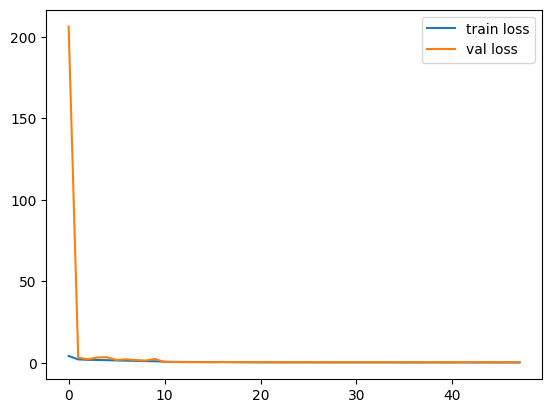

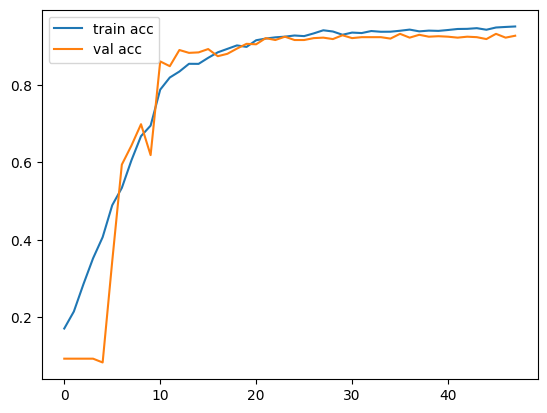

<Figure size 640x480 with 0 Axes>

In [81]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

The two key metrics being used to evaluate the performance of your model are:

Categorical Crossentropy Loss (loss='categorical_crossentropy'): This is a loss function that measures the dissimilarity between the true class labels and the predicted probabilities. It is commonly used for multi-class classification problems 

Accuracy (metrics=['accuracy']): Accuracy is a widely used metric for classification tasks. It measures the ratio of correctly predicted instances to the total number of instances. it represents the percentage of correctly classified car images in both the training and validation datasets.

Based on the provided training history for the last two epochs:



These accuracy values are an indication of how well the model is performing on the classification task. The higher the accuracy, the better the model is at correctly classifying car images. It's important to look at both training and validation accuracy to assess whether the model is overfitting (i.e., performing well on the training data but poorly on unseen data). 

the validation accuracy is close to the training accuracy, suggesting that the model is generalizing well to unseen data.

To summarize, the model is performing well on the classification task, achieving an accuracy of around 92-94% on both the training and validation datasets. 

In [ ]:
#Predications test data

In [54]:

y_pred = model.predict(test_set)


In [55]:
y_pred

array([[4.9484480e-04, 1.6264601e-05, 4.9876604e-08, ..., 4.3519353e-07,
        1.8654418e-08, 9.9948823e-01],
       [9.9923325e-01, 3.1886596e-08, 1.6346821e-05, ..., 1.4597697e-07,
        1.2856311e-06, 1.6910975e-06],
       [9.0483147e-05, 1.0181155e-04, 9.9973267e-01, ..., 5.3417116e-06,
        1.3362401e-05, 4.4991310e-05],
       ...,
       [1.8275303e-09, 2.7658618e-09, 1.4352742e-13, ..., 1.0000000e+00,
        1.0588677e-10, 5.7752483e-09],
       [8.6054235e-05, 4.1282263e-05, 9.6249998e-08, ..., 9.3085415e-05,
        9.9977869e-01, 1.6830202e-07],
       [3.0426646e-03, 1.5796209e-09, 2.5382731e-06, ..., 5.1020194e-08,
        7.3144967e-08, 1.0517252e-08]], dtype=float32)

In [56]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [57]:
y_pred

array([6, 0, 2, 5, 0, 1, 6, 3, 1, 0, 5, 0, 0, 1, 4, 5, 0, 6, 0, 0, 0, 6,
       0, 5, 3, 0, 0, 5, 6, 4, 3, 2, 1, 0, 0, 4, 3, 1, 0, 4, 4, 3, 1, 0,
       6, 0, 6, 1, 2, 0, 6, 1, 0, 6, 2, 0, 4, 0, 4, 6, 5, 2, 5, 6, 5, 0,
       0, 0, 6, 4, 3, 0, 2, 5, 2, 6, 0, 0, 2, 2, 6, 5, 2, 5, 4, 5, 6, 6,
       0, 3, 6, 5, 3, 0, 4, 0, 5, 1, 2, 5, 0, 6, 5, 4, 4, 0, 6, 0, 0, 4,
       0, 2, 6, 4, 0, 3, 4, 6, 5, 6, 0, 5, 1, 6, 0, 6, 0, 5, 0, 5, 3, 4,
       3, 3, 2, 6, 6, 0, 4, 3, 6, 0, 0, 0, 4, 1, 6, 5, 6, 0, 4, 4, 3, 4,
       3, 5, 6, 3, 5, 2, 5, 5, 5, 6, 0, 6, 0, 2, 4, 6, 5, 2, 6, 3, 0, 5,
       3, 6, 0, 5, 0, 3, 6, 6, 6, 6, 0, 6, 5, 0, 4, 6, 4, 6, 3, 2, 0, 5,
       0, 6, 6, 6, 5, 4, 4, 6, 6, 6, 0, 6, 4, 0, 4, 6, 5, 5, 6, 0, 0, 4,
       0, 3, 0, 0, 3, 5, 5, 3, 5, 6, 6, 0, 6, 2, 1, 4, 0, 4, 6, 6, 6, 3,
       2, 6, 0, 6, 6, 5, 2, 0, 0, 6, 0, 6, 6, 3, 3, 0, 0, 2, 3, 0, 6, 5,
       2, 4, 3, 0, 6, 1, 0, 6, 5, 6, 0, 0, 4, 6, 2, 3, 5, 0, 6, 4, 0, 2,
       5, 4, 0, 3, 1, 0, 6, 0, 1, 0, 3, 2, 2, 1, 4,

In [ ]:
#testing the model

In [4]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [5]:
model=load_model('model_resnet50.h5')

In [6]:
model

In [51]:
img=image.load_img('test/Audi/23.jpg',target_size=(224,224))



In [55]:
x=image.img_to_array(img)


In [56]:
x.shape

(224, 224, 3)

In [57]:
x=x/255

In [47]:
x=np.expand_dims(x,axis=0)
#img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [60]:
preds =model.predict(img_data)

1/1 [==============================] - 0s 166ms/step


In [61]:
a=np.argmax(model.predict(img_data), axis=1)

1/1 [==============================] - 0s 222ms/step


In [62]:
preds=np.argmax(preds, axis=1)

In [65]:
preds

array([2], dtype=int64)

In [77]:
#COnverting the model to tensorflow lite for mobile app

In [ ]:
#b.	Mobil app model

In [73]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# load the best saved model from our last training
myModel = load_model('model_resnet50.h5')

In [74]:
# create a TFLiteConverter object from a TensorFlow Keras model 
converter = tf.lite.TFLiteConverter.from_keras_model(myModel)

# converts a Keras model based on instance variable
myModel_tflite = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\hbolla\AppData\Local\Temp\tmp4bq81o_w\assets


INFO:tensorflow:Assets written to: C:\Users\hbolla\AppData\Local\Temp\tmp4bq81o_w\assets


In [75]:
from pathlib import Path

# Save the model
tflite_model_file = Path('car_model_classifier.tflite')
tflite_model_file.write_bytes(myModel_tflite)

# with tf.io.gfile.GFile('clothing_classifier.tflite', mode='wb') as file:
#     file.write(myModel_tflite)

96780488

# By Harsha Teja